In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!wget # Link to Lego photo dataset on Dropbox

In [ ]:
!unzip 'Lego (compressed pics).zip?dl=1'

In [ ]:
data_dir = 'Lego (compressed pics)' 

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor()])
                                      

train_data = datasets.ImageFolder(data_dir + '/Train', transform=data_transform)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=data_transform)

In [ ]:
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  852
Num test images:  58


In [ ]:
# how many samples per batch to load
batch_size = 20   
# number of subprocesses to use for data loading
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# specify the image classes
classes = ['Boy', 'Girl']

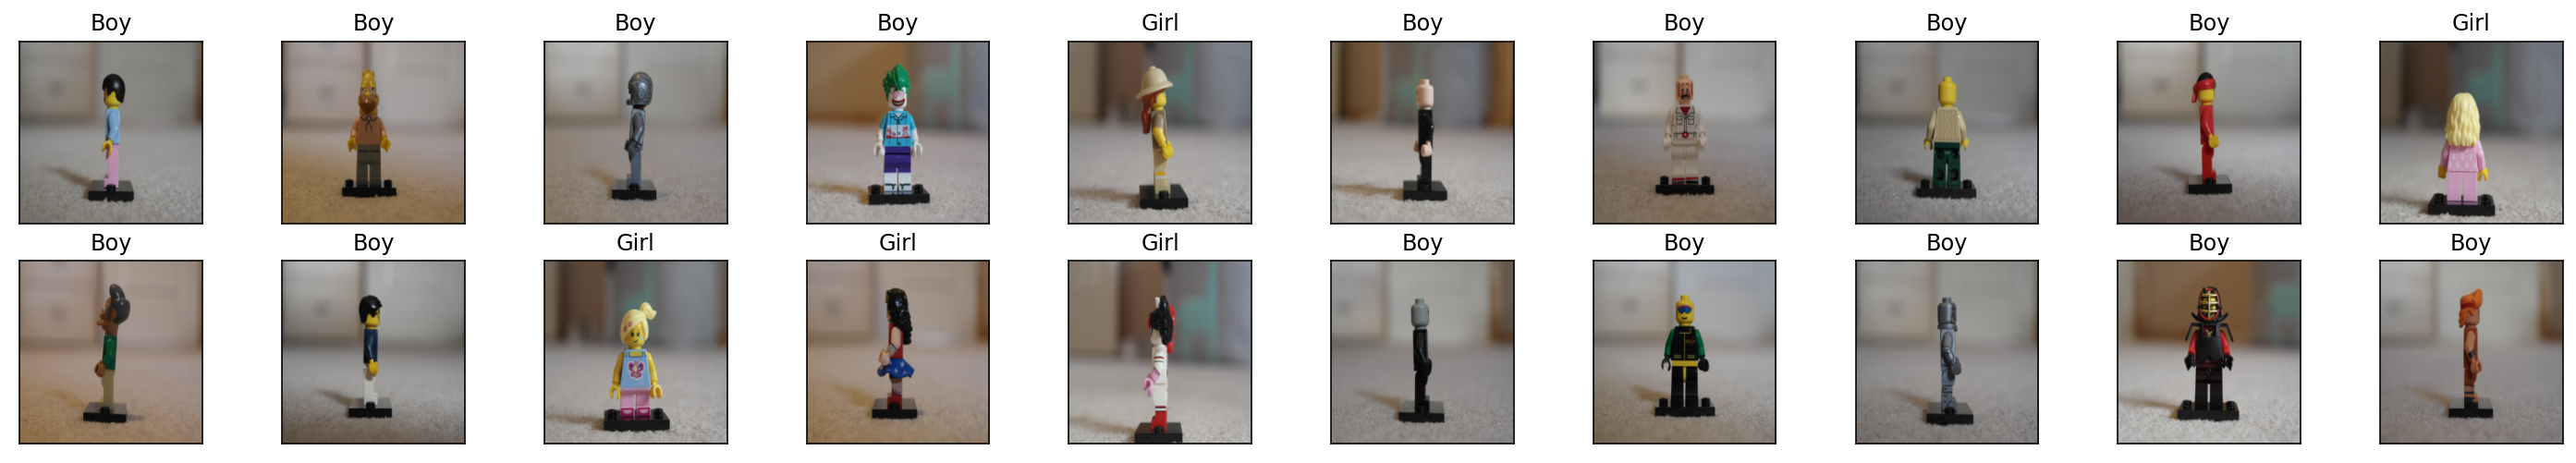

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

In [ ]:
# Load the pretrained model from PyTorch
vgg16 = models.vgg16(pretrained=True)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Freeze training for all feature layers so the model doesn't change the parameters it was pre-trained on
for param in vgg16.features.parameters():
  param.requires_grad = False

In [ ]:
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

if train_on_gpu:
    vgg16.cuda()

In [ ]:
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=2, bias=True)


In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
n_epochs = 2

steps = 0
running_loss = 0
print_every = 20

for epoch in range(n_epochs):
  for inputs, labels in train_loader:
    if train_on_gpu:
      inputs, labels = inputs.cuda(), labels.cuda()
    steps += 1
    optimizer.zero_grad()
    logps = vgg16(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if steps % print_every == 0:
      print('Epoch %d, Batch %d, loss: %.16f' % (epoch+1, steps, running_loss/print_every))
      running_loss = 0

Epoch 1, Batch 20, loss: 0.6777312457561493
Epoch 1, Batch 40, loss: 0.5470919311046600
Epoch 2, Batch 60, loss: 0.5282398015260696
Epoch 2, Batch 80, loss: 0.4542485743761063


In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(classes)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.339564

Test Accuracy of   Boy: 100% ( 4/ 4)
Test Accuracy of  Girl: 50% ( 1/ 2)

Test Accuracy (Overall): 83% ( 5/ 6)


In [ ]:
# monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

vgg16.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  # move to GPU
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = vgg16(data)# calculate the loss
  loss = criterion(output, target)
  # update average test loss 
  test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
  # convert output probabilities to predicted class
  pred = output.data.max(1, keepdim=True)[1]
  # compare predictions to true label
  correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
  total += data.size(0)
            
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

Test Loss: 0.327873


Test Accuracy: 94% (55/58)


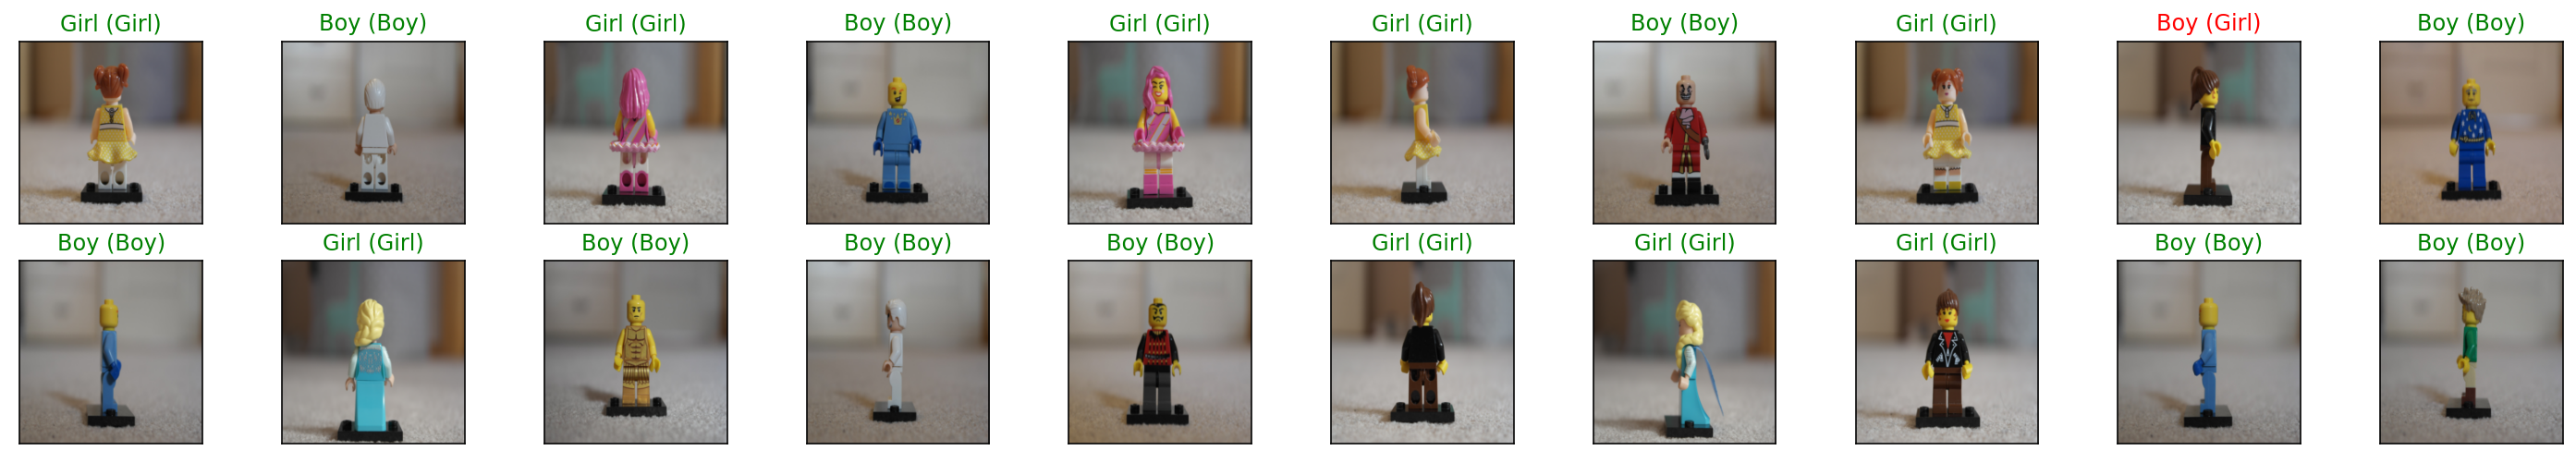

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
  images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))